In [1]:
import netCDF4
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
#NOTE: File paths should be the same if you are working in the repo.
#Also, I would push these csv's but they're bigger than the max file size lmao
wind = xr.open_dataset('../Data/new_raw_data/agg_terraclimate_windspeed_1979_2020.nc')
drought = xr.open_dataset('../Data/new_raw_data/Drought_PDSI_1979_2020_GLOBE.nc')
wind.ws.to_dataframe().to_csv('../Data/new_raw_data/windspeed.csv')
drought.PDSI.to_dataframe().to_csv('../Data/new_raw_data/drought.csv')

In [3]:
wind_df = pd.read_csv('../data/new_raw_data/windspeed.csv')
wind_df = np.round(wind_df, decimals=2)
wind_df.head(5)

,time,lat,lon,ws
0,1979-01-01,40.98,-109.02,2.86
1,1979-01-01,40.98,-108.98,2.84
2,1979-01-01,40.98,-108.94,2.91
3,1979-01-01,40.98,-108.90,2.68
4,1979-01-01,40.98,-108.85,2.56


In [4]:
drought_df = pd.read_csv('../data/new_raw_data/drought.csv')
drought_df = np.round(drought_df, decimals=2)
drought_df.head(5)

,time,lat,lon,PDSI
0,1979-01-01,36.98,-109.02,4.18
1,1979-01-01,36.98,-108.98,4.15
2,1979-01-01,36.98,-108.94,4.11
3,1979-01-01,36.98,-108.90,4.10
4,1979-01-01,36.98,-108.85,3.94


In [5]:
weather_df = pd.merge(wind_df, drought_df, how='outer')
weather_df = weather_df.dropna()
weather_df.head(5)

,time,lat,lon,ws,PDSI
16224,1979-01-01,36.98,-109.02,2.03,4.18
16225,1979-01-01,36.98,-108.98,2.02,4.15
16226,1979-01-01,36.98,-108.94,2.06,4.11
16227,1979-01-01,36.98,-108.90,2.11,4.10
16228,1979-01-01,36.98,-108.85,2.12,3.94


In [6]:
weather_lat_values = weather_df['lat'].unique()
weather_lon_values = weather_df['lon'].unique()

In [7]:
wildfire_df = pd.read_csv('../Data/Clean Data/Wildfires/cleaned_wildfires.csv')
wildfire_df = np.round(wildfire_df, decimals=2)
wildfire_df['DISCOVERY_DATE'].apply(str)
wildfire_df.head()

,LATITUDE,LONGITUDE,DISCOVERY_DATE
0,37.34,-102.81,2005-07-07
1,39.44,-105.12,2005-06-28
2,37.22,-103.20,2005-07-24
3,37.04,-102.59,2005-07-24
4,37.31,-102.72,2005-07-17


In [8]:
date_list = wildfire_df['DISCOVERY_DATE'].tolist()
fire_list = []
for i in range(len(date_list)):
    fire_list.append(1)
    if not date_list[i].endswith('01'):
        date_list[i] = date_list[i][:-2] + "01"
wildfire_df['time'] = date_list
wildfire_df['fire'] = fire_list
wildfire_df = wildfire_df.drop(['DISCOVERY_DATE'], axis=1)
wildfire_df = wildfire_df.rename({'LATITUDE': 'lat', 'LONGITUDE': 'lon'}, axis=1)
wildfire_df = wildfire_df[['time', 'lat', 'lon', 'fire']]
wildfire_df.head()

,time,lat,lon,fire
0,2005-07-01,37.34,-102.81,1
1,2005-06-01,39.44,-105.12,1
2,2005-07-01,37.22,-103.20,1
3,2005-07-01,37.04,-102.59,1
4,2005-07-01,37.31,-102.72,1


In [9]:
def closest(lst, num):
      
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-num))]

In [10]:
wildfire_lat_values = wildfire_df['lat'].tolist()
wildfire_lon_values = wildfire_df['lon'].tolist()

In [11]:
wildfire_lat_new = []
for i in wildfire_lat_values:
    wildfire_lat_new.append(closest(weather_lat_values, i))

In [12]:
wildfire_lon_new = []
for j in wildfire_lon_values:
    wildfire_lon_new.append(closest(weather_lon_values, j))

In [13]:
wildfire_df_new = pd.DataFrame(columns=['time', 'lat', 'lon', 'fire'])
wildfire_df_new['time'] = wildfire_df['time']
wildfire_df_new['lat'] = wildfire_lat_new
wildfire_df_new['lon'] = wildfire_lon_new
wildfire_df_new['fire'] = wildfire_df['fire']
wildfire_df_new.head()

,time,lat,lon,fire
0,2005-07-01,36.98,-102.81,1
1,2005-06-01,36.98,-105.10,1
2,2005-07-01,36.98,-103.19,1
3,2005-07-01,36.98,-102.60,1
4,2005-07-01,36.98,-102.73,1


In [14]:
date_list = wildfire_df_new['time'].tolist()
date_list2 = []
fire_list = []
lat_list = wildfire_df_new['lat'].tolist()
lat_list2 = []
lon_list = wildfire_df_new['lon'].tolist()
lon_list2 = []
for i in range(len(date_list)):
    if date_list[i].endswith('05-01') or date_list[i].endswith('06-01') or date_list[i].endswith('07-01') or date_list[i].endswith('08-01'):
        fire_list.append(1)
        date_list2.append(date_list[i])
        lat_list2.append(lat_list[i])
        lon_list2.append(lon_list[i])
wildfire_df_may2aug = pd.DataFrame(columns=['time', 'lat', 'lon', 'fire'])
wildfire_df_may2aug['time'] = date_list2
wildfire_df_may2aug['lat'] = lat_list2
wildfire_df_may2aug['lon'] = lon_list2
wildfire_df_may2aug['fire'] = fire_list
# wildfire_df_may2aug = wildfire_df_may2aug.drop(['DISCOVERY_DATE'], axis=1)
# wildfire_df_may2aug = wildfire_df_may2aug.rename({'LATITUDE': 'lat', 'LONGITUDE': 'lon'}, axis=1)
# wildfire_df_may2aug = wildfire_df_may2aug[['time', 'lat', 'lon', 'fire']]
wildfire_df_may2aug.head()

,time,lat,lon,fire
0,2005-07-01,36.98,-102.81,1
1,2005-06-01,36.98,-105.10,1
2,2005-07-01,36.98,-103.19,1
3,2005-07-01,36.98,-102.60,1
4,2005-07-01,36.98,-102.73,1


In [15]:
wildfire_df_may2aug.shape

(1010, 4)

In [16]:
final_df = pd.merge(weather_df, wildfire_df_may2aug, how='outer')
final_df.head()

,time,lat,lon,ws,PDSI,fire
0,1979-01-01,36.98,-109.02,2.03,4.18,NaN
1,1979-01-01,36.98,-108.98,2.02,4.15,NaN
2,1979-01-01,36.98,-108.94,2.06,4.11,NaN
3,1979-01-01,36.98,-108.90,2.11,4.10,NaN
4,1979-01-01,36.98,-108.85,2.12,3.94,NaN


In [17]:
date_list = final_df['time'].tolist()
date_list2 = []
lat_list = final_df['lat'].tolist()
lat_list2 = []
lon_list = final_df['lon'].tolist()
lon_list2 = []
ws_list = final_df['ws'].tolist()
ws_list2 = []
PDSI_list = final_df['PDSI'].tolist()
PDSI_list2 = []
fire_list = final_df['fire'].tolist()
fire_list2 = []
for i in range(len(date_list)):
    if date_list[i].endswith('05-01') or date_list[i].endswith('06-01') or date_list[i].endswith('07-01') or date_list[i].endswith('08-01'):
        fire_list.append(1)
        date_list2.append(date_list[i])
        lat_list2.append(lat_list[i])
        lon_list2.append(lon_list[i])
        ws_list2.append(ws_list[i])
        PDSI_list2.append(PDSI_list[i])
        fire_list2.append(fire_list[i])
final_df_may2aug = pd.DataFrame(columns=['time', 'lat', 'lon', 'ws', 'PDSI', 'fire'])
final_df_may2aug['time'] = date_list2
final_df_may2aug['lat'] = lat_list2
final_df_may2aug['lon'] = lon_list2
final_df_may2aug['ws'] = ws_list2
final_df_may2aug['PDSI'] = PDSI_list2
final_df_may2aug['fire'] = fire_list2
final_df_may2aug.head()

,time,lat,lon,ws,PDSI,fire
0,1979-05-01,36.98,-109.02,2.63,6.78,NaN
1,1979-05-01,36.98,-108.98,2.63,7.07,NaN
2,1979-05-01,36.98,-108.94,2.63,7.02,NaN
3,1979-05-01,36.98,-108.90,2.64,6.99,NaN
4,1979-05-01,36.98,-108.85,2.64,7.05,NaN


In [18]:
final_df_may2aug = final_df_may2aug[final_df_may2aug['time'].between('2000-05-01', '2015-08-01')]
final_df_may2aug.tail()

,time,lat,lon,ws,PDSI,fire
25175,2015-08-01,36.98,-102.19,3.93,5.94,NaN
25176,2015-08-01,36.98,-102.15,3.93,5.76,NaN
25177,2015-08-01,36.98,-102.10,3.92,5.54,NaN
25178,2015-08-01,36.98,-102.06,3.92,5.37,NaN
25179,2015-08-01,36.98,-102.02,3.92,4.87,NaN


In [19]:
final_df_may2aug = final_df_may2aug[final_df_may2aug['ws'].notna()]
final_df_may2aug = final_df_may2aug[final_df_may2aug['PDSI'].notna()]
final_df_may2aug[['fire']] = final_df_may2aug[['fire']].fillna(value=0)
final_df_may2aug.fire = final_df_may2aug.fire.astype(int)
# print (sum(final_df_may2aug['fire']))
# final_df_may2aug.dtypes
# print(final_df_may2aug['fire'].unique())
final_df_may2aug_nofire = final_df_may2aug[final_df_may2aug['fire'] == 0]
final_df_may2aug_fireonly = final_df_may2aug[final_df_may2aug['fire'] == 1]
# final_df_may2aug_nofire.head()
# final_df_may2aug_fireonly.head()

In [20]:
final_df_may2aug_nofire = final_df_may2aug_nofire.head(final_df_may2aug_fireonly.shape[0])
final_df_may2aug_equal = final_df_may2aug_fireonly.append(final_df_may2aug_nofire, ignore_index=True)
final_df_may2aug_equal.head()

,time,lat,lon,ws,PDSI,fire
0,2000-05-01,36.98,-108.85,3.60,-3.66,1
1,2000-05-01,36.98,-108.69,3.63,-4.02,1
2,2000-05-01,36.98,-108.65,3.67,-4.12,1
3,2000-05-01,36.98,-108.56,3.69,-4.10,1
4,2000-05-01,36.98,-108.52,3.66,-4.10,1


In [21]:
#NOTE: Only run this if you want to get a csv from the data
# final_df_may2aug_equal.to_csv("../Data/Clean Data/final_data.csv", encoding='utf-8', index=False)

In [22]:
# Split up the independent and dependent variables, where the independent variables are the lattitude, longitude, wind speed, and PDSI. The dependent is whether there was a fire or not
x = final_df_may2aug_equal[['lat','lon','ws', 'PDSI']]
y = final_df_may2aug_equal['fire']

# Pick what fraction of the data you want to be the testing data
fraction_split = 0.1

In [23]:
#split the data into training and testing data using sklearn function train_test_split
train_x, test_x, train_y, test_y = train_test_split(x,y, test_size=fraction_split)
print(train_x)

        lat     lon    ws  PDSI
715   36.98 -108.60  2.67  2.61
1063  36.98 -106.31  4.94 -1.53
159   36.98 -103.77  5.70 -3.64
706   36.98 -104.35  5.45  0.93
411   36.98 -103.15  4.97 -1.56
...     ...     ...   ...   ...
628   36.98 -107.85  2.71  0.66
292   36.98 -109.02  2.22 -3.21
1078  36.98 -105.69  4.69 -3.36
488   36.98 -108.44  2.41 -3.30
828   36.98 -107.52  3.28 -3.07

[1818 rows x 4 columns]


In [24]:
# Output the training and testing data to two csvs in Clean Data folder
train_x = pd.DataFrame(train_x)
train_y = pd.DataFrame(train_y)

test_x = pd.DataFrame(test_x)
test_y = pd.DataFrame(test_y)


training_data = train_x.assign(fire = train_y)
testing_data = test_x.assign(fire = test_y)

print(training_data)
# training_data.to_csv("../Data/Clean Data/training_data.csv", encoding='utf-8', index=False)
# testing_data.to_csv("../Data/Clean Data/testing_data.csv", encoding='utf-8', index=False)

        lat     lon    ws  PDSI  fire
715   36.98 -108.60  2.67  2.61     1
1063  36.98 -106.31  4.94 -1.53     0
159   36.98 -103.77  5.70 -3.64     1
706   36.98 -104.35  5.45  0.93     1
411   36.98 -103.15  4.97 -1.56     1
...     ...     ...   ...   ...   ...
628   36.98 -107.85  2.71  0.66     1
292   36.98 -109.02  2.22 -3.21     1
1078  36.98 -105.69  4.69 -3.36     0
488   36.98 -108.44  2.41 -3.30     1
828   36.98 -107.52  3.28 -3.07     1

[1818 rows x 5 columns]


In [25]:
model = svm.SVC()
model.fit(train_x, train_y)

C:\Users\Cole\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

In [26]:
y_pred = model.predict(test_x)

In [27]:
print(y_pred)

[0 0 1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 0 0 0 1 0 0 1 0 1 0 0 0 1 0 1 1 1 0 0
 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 0 1 0 1 0 1 1 1 0 0 1 0 1 1 0 1 0 1 1 1
 0 0 1 1 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1 1 1 0 1 1
 0 1 1 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1
 0 0 0 0 1 0 1 1 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 0 1
 1 1 0 0 1 1 0 1 1 1 0 0 1 0 0 1 1]


In [28]:
print("Score:", accuracy_score(test_y, y_pred))

Score: 0.6831683168316832


In [29]:
df_final = test_x.iloc[:, 2:4]
df_final['fire'] = y_pred
# print (df_final)

C:\Users\Cole\AppData\Local\Temp/ipykernel_22644/3788452596.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['fire'] = y_pred


In [30]:
def heat_map(df, size=10):
    corr = df.corr()  #the default method is pearson
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr,cmap=plt.cm.Oranges)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)    
    plt.show()

<AxesSubplot:>

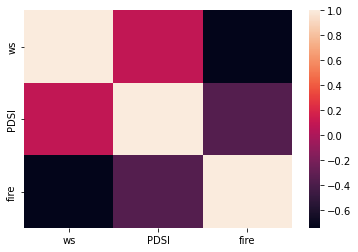

In [31]:
corr = df_final.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [32]:
print (testing_data)

        lat     lon    ws  PDSI  fire
1991  36.98 -106.15  3.27  1.48     0
1888  36.98 -104.27  4.95  1.82     0
908   36.98 -106.94  3.52 -4.69     1
1650  36.98 -107.65  3.48  1.23     0
867   36.98 -108.65  2.41 -2.56     1
...     ...     ...   ...   ...   ...
600   36.98 -108.19  2.43  1.71     1
400   36.98 -105.35  4.29  1.01     1
1566  36.98 -104.23  4.02 -3.11     0
1169  36.98 -108.73  2.99 -3.84     0
1943  36.98 -108.77  2.67 -1.72     0

[202 rows x 5 columns]


In [33]:
if sum(testing_data['fire']) == sum(testing_data['fire']&df_final['fire']):
    print("The model correctly predict all of the actual fires")
else:
    print("The model did not predict all of the actual fires.")
    print("There were", sum(testing_data['fire'])-sum(testing_data['fire']&df_final['fire']),"unidentified fires.")
    print("There were",sum(testing_data['fire']&df_final['fire']),"correctly identified fires.")
    print("There were",sum(df_final['fire'])-sum(testing_data['fire']&df_final['fire']),"incorrectly identified fires.")

The model did not predict all of the actual fires.
There were 25 unidentified fires.
There were 80 correctly identified fires.
There were 39 incorrectly identified fires.
